# Análisis de Consumo Energético y Clustering con K-Means

## Objetivos del Cuaderno

1. **Generación de Features Agregadas**: Crear nuevas características a partir de los datos originales para representar patrones de consumo de manera más significativa y reducir la dimensionalidad.
2. **Manejo de Valores Faltantes** (KNNImputer o SoftImpute)
3. **Escalado de Características** (`StandardScaler`)

4. **Selección del Número de Clusters (K)**: Probar diferentes metodos para obtener valores de K y determinar el número óptimo de clusters.
    - **Método del Codo**: Graficar la inercia en función de K y buscar el "codo" en la gráfica.
    - **Silhouette Score**: Calcular el coeficiente de silueta para diferentes valores de K y graficar los resultados.
    - **Davies-Bouldin Index**: Calcular el índice de Davies-Bouldin para diferentes valores de K y graficar los resultados.
    - **K-ISAC-TLP**: Utilizar el método K-ISAC-TLP para determinar el número óptimo de clusters.
        - **ISAC Curves**: Graficar las curvas ISAC para diferentes valores de K y observar la tendencia.
        - **MAE**: Calcular el error absoluto medio (MAE) para diferentes valores de K y graficar los resultados.
        - **Irrelevant clusters**: Identificar y eliminar clusters irrelevantes que no aporten información significativa.
5. **Clustering con K-Means**: Aplicar el algoritmo de K-Means para agrupar las viviendas en función de sus patrones de consumo energético.
6. **Validación del Modelo**: Evaluar la calidad de los clusters generados utilizando metedos y visualizaciones adecuadas.
    -  **Visualización de Clusters**: Graficar los clusters generados para observar la distribución de los datos y la separación entre los grupos
        - **Análisis de Componentes Principales (PCA)**: Para la visualizazacion 2D de los cluster

## Introducción

El dataset contiene información horaria del consumo energético de aproximadamente 130 viviendas durante un período de dos años. Cada registro incluye:
- **CUPS**: Identificador único de la vivienda.
- **Fecha**: Día específico del registro.
- **Hora**: Hora del día (1 a 24).
- **Consumo_kWh**: Consumo energético en kilovatios-hora.

Dado el volumen de datos, es necesario crear características agregadas que representen patrones de consumo a nivel diario, semanal, mensual, etc., para facilitar el análisis y el clustering.


## Preprocesamiento y Generación de Features

Antes de aplicar el clustering, comenzaremos con:
1. Preprocesamiento y Generación de Features
    - Justificación del Pipeline:
    El preprocesamiento sistemático es crítico porque:
        - **Consistencia**: Las estaciones y tipos de día (laborable/fin de semana) tienen patrones de consumo fundamentalmente distintos.
        - **Robustez**: Las métricas propuestas (percentiles, Lyapunov, FFT) capturan tanto comportamientos típicos como anomalías.
        - **Interpretabilidad**: La separación por contextos naturales (estaciones) facilita la acción sobre resultados.
2. **Creación de Features Agregadas**:
    **Subanálisis (por vivienda):**
    - Primavera
    - Verano
    - Otoño
    - Invierno
    - Análisis general

    **Dentro de cada subanálisis:**
    - Separar en:
    - Días laborables
    - Fines de semana

    **Métricas a calcular para cada parte:**
    | Variable                        | Descripción                                      |
    |---------------------------------|--------------------------------------------------|
    | Media y Desviación Estándar     | Tendencia central y dispersión                  |
    | Asimetría (Skewness)            | Simetría de la distribución                     |
    | Curtosis                        | Picudez/plenitud de la distribución             |
    | Energía (FFT)                   | Potencia acumulada de la señal                  |
    | Frecuencia dominante (FFT)      | Periodicidad más fuerte                         |
    | Mediana y percentiles (25, 75)  | Distribución robusta                            |

3. **Normalización de Datos**: Escalar las características para que todas tengan el mismo rango y no dominen el análisis.

Una vez que los datos estén preprocesados y las nuevas características estén listas, procederemos con la aplicación de K-Means y la evaluación de los resultados.

Imports

In [202]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fft import fft
import re
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import seaborn as sns
import random
import math
from sklearn.impute import KNNImputer
from fancyimpute import SoftImpute
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, mean_absolute_error, davies_bouldin_score
import warnings

warnings.filterwarnings("ignore")

In [203]:
df = pd.read_csv("../../../data/vertical_preprocessed_data_2.csv", sep=";")

Funciones

In [204]:
def obtener_estacion(mes):
    if mes in [12, 1, 2]:
        return 'invierno'
    elif mes in [3, 4, 5]:
        return 'primavera'
    elif mes in [6, 7, 8]:
        return 'verano'
    else:
        return 'otoño'


def calcular_features(consumos):
    consumos = np.array(consumos)
    if len(consumos) < 2:
        return dict.fromkeys([
            'media', 'std', 'skewness', 'kurtosis',
            'energia_fft', 'frecuencia_dominante',
            'mediana', 'p25', 'p75'
        ], np.nan)

    media = np.mean(consumos)
    std = np.std(consumos)
    skewness = skew(consumos)
    kurt = kurtosis(consumos)

    fft_vals = fft(consumos)
    fft_powers = np.abs(fft_vals)**2
    energia = np.sum(fft_powers) / len(fft_powers)
    frec_dom = np.argmax(fft_powers[1:]) + 1 if len(fft_powers) > 1 else np.nan

    return {
        'media': media,
        'std': std,
        'skewness': skewness,
        'kurtosis': kurt,
        'energia_fft': energia,
        'frecuencia_dominante': frec_dom,
        'mediana': np.median(consumos),
        'p25': np.percentile(consumos, 25),
        'p75': np.percentile(consumos, 75)
    }

In [205]:
df['fecha'] = pd.to_datetime(df['fecha'])
df['hora'] = df['hora'].astype(int)
df['dia_semana'] = df['fecha'].dt.dayofweek
df['es_fin_de_semana'] = df['dia_semana'] >= 5
df['mes'] = df['fecha'].dt.month

df['estacion'] = df['mes'].apply(obtener_estacion)

df_grouped = df.groupby(['cups', 'fecha', 'estacion'])['consumo_kWh'].apply(list).reset_index()

# Diccionario donde las claves serán cups y los valores serán diccionarios de features
features_por_cups = {}

# 1. Subanálisis por estación (sin dividir por tipo de día)
for (cups, estacion), grupo in df_grouped.groupby(['cups', 'estacion']):
    consumos = sum(grupo['consumo_kWh'].tolist(), [])
    feats = calcular_features(consumos)
    prefix = f"{estacion}"

    if cups not in features_por_cups:
        features_por_cups[cups] = {}

    for key, val in feats.items():
        features_por_cups[cups][f"{key}_{prefix}"] = val

# 2. Subanálisis ANUAL completo (sin dividir) - Se mantiene igual
for cups, grupo in df_grouped.groupby('cups'):
    consumos = sum(grupo['consumo_kWh'].tolist(), [])
    feats = calcular_features(consumos)
    for key, val in feats.items():
        features_por_cups[cups][f"{key}_anual"] = val

df_features_final = pd.DataFrame.from_dict(features_por_cups, orient='index')
df_features_final.reset_index(inplace=True)
df_features_final.rename(columns={'index': 'cups'}, inplace=True)
df_features_final.set_index('cups', inplace=True)

In [206]:
# df['fecha'] = pd.to_datetime(df['fecha'])
# df['hora'] = df['hora'].astype(int)
# df['dia_semana'] = df['fecha'].dt.dayofweek
# df['es_fin_de_semana'] = df['dia_semana'] >= 5
# df['mes'] = df['fecha'].dt.month

# df['estacion'] = df['mes'].apply(obtener_estacion)

# df_grouped = df.groupby(['cups', 'fecha', 'es_fin_de_semana', 'estacion'])['consumo_kWh'].apply(list).reset_index()

# # Diccionario donde las claves serán cups y los valores serán diccionarios de features
# features_por_cups = {}

# # 1. Subanálisis por estación y tipo de día (laboral/finde)
# for (cups, estacion, es_finde), grupo in df_grouped.groupby(['cups', 'estacion', 'es_fin_de_semana']):
#     consumos = sum(grupo['consumo_kWh'].tolist(), [])
#     feats = calcular_features(consumos)
#     tipo_dia = 'finde' if es_finde else 'laboral'
#     prefix = f"{estacion}_{tipo_dia}"
    
#     if cups not in features_por_cups:
#         features_por_cups[cups] = {}
    
#     for key, val in feats.items():
#         features_por_cups[cups][f"{key}_{prefix}"] = val

# # 2. Subanálisis ANUAL dividido en laboral/finde
# for (cups, es_finde), grupo in df_grouped.groupby(['cups', 'es_fin_de_semana']):
#     consumos = sum(grupo['consumo_kWh'].tolist(), [])
#     feats = calcular_features(consumos)
#     tipo_dia = 'finde' if es_finde else 'laboral'
#     prefix = f"anual_{tipo_dia}"  # Cambiado a "anual_laboral" y "anual_finde"
    
#     for key, val in feats.items():
#         features_por_cups[cups][f"{key}_{prefix}"] = val

# # 3. Subanálisis ANUAL completo (sin dividir)
# for cups, grupo in df_grouped.groupby('cups'):
#     consumos = sum(grupo['consumo_kWh'].tolist(), [])
#     feats = calcular_features(consumos)
#     for key, val in feats.items():
#         features_por_cups[cups][f"{key}_anual"] = val  # Se mantiene igual

# df_features_final = pd.DataFrame.from_dict(features_por_cups, orient='index')
# df_features_final.reset_index(inplace=True)
# df_features_final.rename(columns={'index': 'cups'}, inplace=True)
# df_features_final.set_index('cups', inplace=True)

### Matriz de Correlación

Matriz de Correlación:
                                 media_invierno  std_invierno  \
media_invierno                        1.000000      0.840128   
std_invierno                          0.840128      1.000000   
skewness_invierno                    -0.645887     -0.544706   
kurtosis_invierno                    -0.493550     -0.480077   
energia_fft_invierno                  0.839330      0.874305   
frecuencia_dominante_invierno        -0.104640     -0.068603   
mediana_invierno                      0.866193      0.482343   
p25_invierno                          0.693958      0.280306   
p75_invierno                          0.948512      0.725276   
media_otoño                           0.880786      0.669790   
std_otoño                             0.877199      0.918304   
skewness_otoño                       -0.465249     -0.237981   
kurtosis_otoño                       -0.461140     -0.335243   
energia_fft_otoño                     0.861430      0.830564   
frecuencia_domin

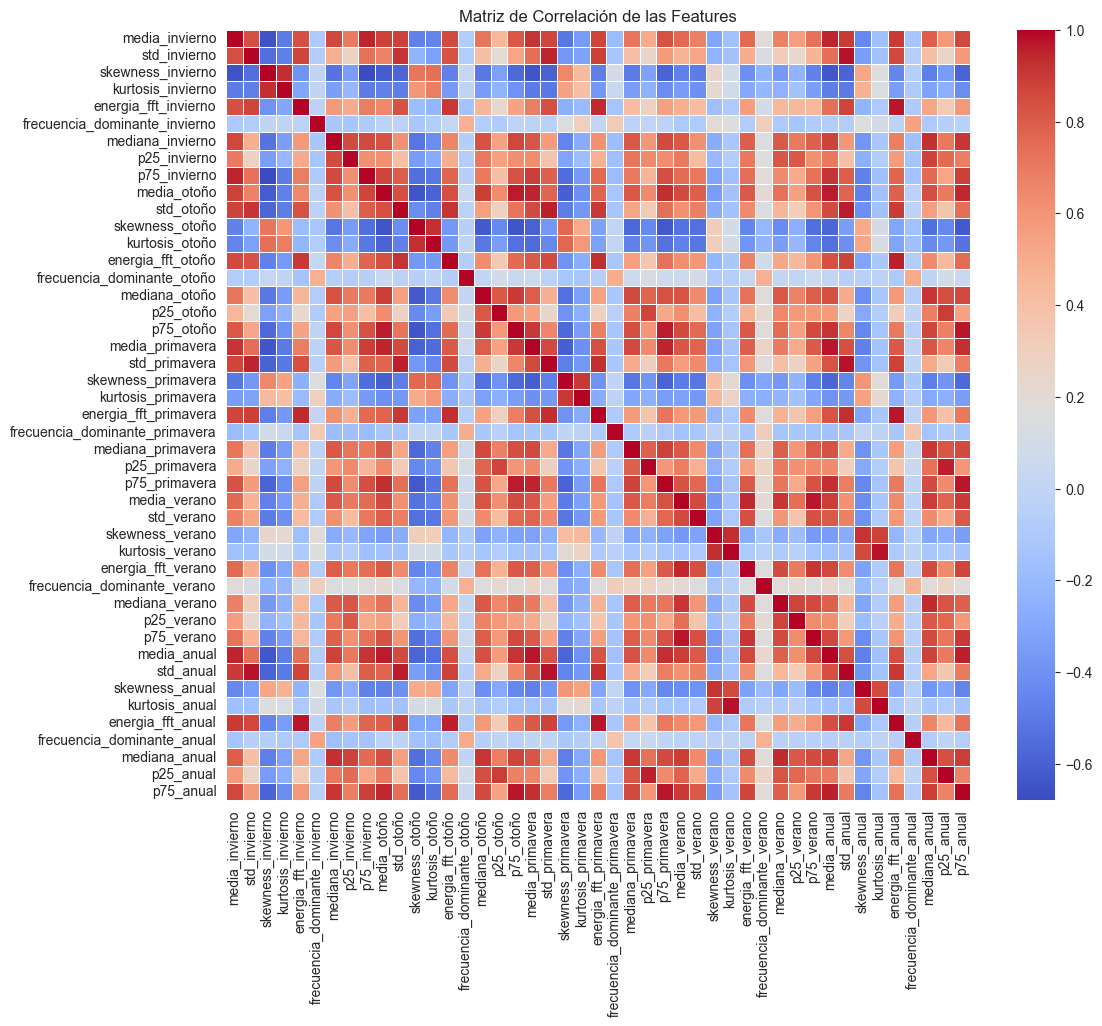


Pares de variables altamente correlacionadas (abs(corr) > 0.8):
 [('std_invierno', 'media_invierno'), ('kurtosis_invierno', 'skewness_invierno'), ('energia_fft_invierno', 'media_invierno'), ('energia_fft_invierno', 'std_invierno'), ('mediana_invierno', 'media_invierno'), ('p25_invierno', 'mediana_invierno'), ('p75_invierno', 'media_invierno'), ('p75_invierno', 'mediana_invierno'), ('media_otoño', 'media_invierno'), ('media_otoño', 'mediana_invierno'), ('media_otoño', 'p75_invierno'), ('std_otoño', 'media_invierno'), ('std_otoño', 'std_invierno'), ('std_otoño', 'energia_fft_invierno'), ('std_otoño', 'p75_invierno'), ('std_otoño', 'media_otoño'), ('kurtosis_otoño', 'skewness_otoño'), ('energia_fft_otoño', 'media_invierno'), ('energia_fft_otoño', 'std_invierno'), ('energia_fft_otoño', 'energia_fft_invierno'), ('energia_fft_otoño', 'media_otoño'), ('energia_fft_otoño', 'std_otoño'), ('mediana_otoño', 'mediana_invierno'), ('mediana_otoño', 'media_otoño'), ('p25_otoño', 'mediana_otoño'), ('

In [207]:
correlation_matrix = df_features_final.corr()

print("Matriz de Correlación:\n", correlation_matrix)

#Heatmap de la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación de las Features')
plt.show()

upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated_pairs = [(column, row) for column in upper_triangle.columns for row in upper_triangle.index if abs(upper_triangle.loc[row, column]) > 0.8]

print("\nPares de variables altamente correlacionadas (abs(corr) > 0.8):\n", highly_correlated_pairs)

### Correcion de errores y NaN

In [208]:
df_drop = df_features_final.copy()
# Voy a eliminar dos filas (cups) que tienen NaN durante todo el invierno
cups_con_nan_invierno = ['ceaddbf817fc', 'd0fbcc1108d8']
df_drop.drop(index=cups_con_nan_invierno, inplace=True, errors='ignore')

# Voy a eliminar tres filas (cups) que tienen NaN durante todo el otoño
cups_con_nan_otoño = ['83c7fbada9b4', 'b476034a2e3d', 'ba38270a360e']
df_drop.drop(index=cups_con_nan_otoño, inplace=True, errors='ignore')

**Técnicas Implementadas**

### 1. KNNImputer

* **Concepto:** Imputación basada en los $k$-vecinos más cercanos ($k=5$).
* **Ventajas:**
    * Mantiene relaciones no lineales entre variables.
    * Considera la similitud entre registros completos.

### 2. SoftImpute

* **Concepto:** Imputación basada en factorización matricial (descomposición SVD).
* **Ventajas:**
    * Eficiente para matrices grandes y dispersas.
    * Maneja bien patrones de datos faltantes aleatorios.


In [209]:
# Opción 1: KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)
df_knn = pd.DataFrame(
    knn_imputer.fit_transform(df_features_final),
    columns=df_features_final.columns,
    index=df_features_final.index
)
df_knn.to_csv("dataset/features_KNNImputer.csv")

# Opción 2: SoftImpute
soft_imputer = SoftImpute()
df_soft = pd.DataFrame(
    soft_imputer.fit_transform(df_features_final),
    columns=df_features_final.columns,
    index=df_features_final.index
)
df_soft.to_csv("dataset/features_SoftImpute.csv")

# Opción 3: Dataset original (sin imputar) para comparación
df_drop.to_csv("dataset/features_drop.csv")

[SoftImpute] Max Singular Value of X_init = 115082.524340
[SoftImpute] Iter 1: observed MAE=23.523659 rank=6
[SoftImpute] Iter 2: observed MAE=23.523622 rank=6
[SoftImpute] Iter 3: observed MAE=23.523051 rank=6
[SoftImpute] Iter 4: observed MAE=23.524372 rank=6
[SoftImpute] Iter 5: observed MAE=23.525516 rank=6
[SoftImpute] Iter 6: observed MAE=23.525970 rank=6
[SoftImpute] Iter 7: observed MAE=23.526142 rank=6
[SoftImpute] Iter 8: observed MAE=23.526207 rank=6
[SoftImpute] Stopped after iteration 8 for lambda=2301.650487


In [210]:
tiene_nans = df_knn.isnull().any().any()

if tiene_nans:

    columnas_con_nans = df_features_final.columns[df_features_final.isnull().any()].tolist()
    print(f"Las columnas con valores NaN son: {columnas_con_nans}")

    nans_por_columna = df_features_final.isnull().sum()
    print("\nNúmero de NaNs por columna:")
    print(nans_por_columna[nans_por_columna > 0])

else:
    print("El dataset no contiene ningún valor NaN.")

El dataset no contiene ningún valor NaN.


### Aqui eligimos con que dataset hacemos las cosas (por ahora KNNIMPUTER)

In [211]:
df = pd.read_csv("dataset/features_KNNImputer.csv", index_col='cups')

In [212]:
num_columnas = df.shape[1]
print(f"El DataFrame df_features_final tiene {num_columnas} columnas.")
nombres_columnas = df.columns.tolist()
print(f"Los nombres de las columnas son: {nombres_columnas}")

El DataFrame df_features_final tiene 45 columnas.
Los nombres de las columnas son: ['media_invierno', 'std_invierno', 'skewness_invierno', 'kurtosis_invierno', 'energia_fft_invierno', 'frecuencia_dominante_invierno', 'mediana_invierno', 'p25_invierno', 'p75_invierno', 'media_otoño', 'std_otoño', 'skewness_otoño', 'kurtosis_otoño', 'energia_fft_otoño', 'frecuencia_dominante_otoño', 'mediana_otoño', 'p25_otoño', 'p75_otoño', 'media_primavera', 'std_primavera', 'skewness_primavera', 'kurtosis_primavera', 'energia_fft_primavera', 'frecuencia_dominante_primavera', 'mediana_primavera', 'p25_primavera', 'p75_primavera', 'media_verano', 'std_verano', 'skewness_verano', 'kurtosis_verano', 'energia_fft_verano', 'frecuencia_dominante_verano', 'mediana_verano', 'p25_verano', 'p75_verano', 'media_anual', 'std_anual', 'skewness_anual', 'kurtosis_anual', 'energia_fft_anual', 'frecuencia_dominante_anual', 'mediana_anual', 'p25_anual', 'p75_anual']


In [213]:
columnas_invierno = [col for col in nombres_columnas if re.search(r'_invierno', col)]
columnas_primavera = [col for col in nombres_columnas if re.search(r'_primavera', col)]
columnas_verano = [col for col in nombres_columnas if re.search(r'_verano', col)]
columnas_otoño = [col for col in nombres_columnas if re.search(r'_otoño', col)]
columnas_anuales = [col for col in nombres_columnas if re.search(r'_anual', col)]

print("\nColumnas relacionadas con Invierno:")
print(len(columnas_invierno))
print(columnas_invierno)
print("\nColumnas relacionadas con Primavera:")
print(len(columnas_primavera))
print(columnas_primavera)
print("\nColumnas relacionadas con Verano:")
print(len(columnas_verano))
print(columnas_verano)
print("\nColumnas relacionadas con Otoño:")
print(len(columnas_otoño))
print(columnas_otoño)
print("\nColumnas con agregación Anual:")
print(len(columnas_anuales))
print(columnas_anuales)


Columnas relacionadas con Invierno:
9
['media_invierno', 'std_invierno', 'skewness_invierno', 'kurtosis_invierno', 'energia_fft_invierno', 'frecuencia_dominante_invierno', 'mediana_invierno', 'p25_invierno', 'p75_invierno']

Columnas relacionadas con Primavera:
9
['media_primavera', 'std_primavera', 'skewness_primavera', 'kurtosis_primavera', 'energia_fft_primavera', 'frecuencia_dominante_primavera', 'mediana_primavera', 'p25_primavera', 'p75_primavera']

Columnas relacionadas con Verano:
9
['media_verano', 'std_verano', 'skewness_verano', 'kurtosis_verano', 'energia_fft_verano', 'frecuencia_dominante_verano', 'mediana_verano', 'p25_verano', 'p75_verano']

Columnas relacionadas con Otoño:
9
['media_otoño', 'std_otoño', 'skewness_otoño', 'kurtosis_otoño', 'energia_fft_otoño', 'frecuencia_dominante_otoño', 'mediana_otoño', 'p25_otoño', 'p75_otoño']

Columnas con agregación Anual:
9
['media_anual', 'std_anual', 'skewness_anual', 'kurtosis_anual', 'energia_fft_anual', 'frecuencia_dominant

Falta poir quitar las ultimas dos cups que no tienen datos de invierno por ahora
luego normalizar los datos
luego aplicar kmeans y por metedos de sacar k

### StandardScaler

StandardScaler, es una técnica fundamental de preprocesamiento de datos utilizada en machine learning, especialmente antes de aplicar algoritmos sensibles a la escala de las características (features). Su objetivo principal es transformar las características de manera que tengan una media de 0 y una desviación estándar de 1.

**La Fórmula Matemática:**

Para cada valor \(x_i\) de una característica dada, StandardScaler aplica la siguiente fórmula:

$$
z_i = \frac{x_i - \mu}{\sigma}
$$

Donde:

* \(z_i\) es el valor escalado (el z-score) del dato \(x_i\).
* \(x_i\) es el valor original del dato.
* \(\mu\) (mu) es la media de todos los valores de esa característica en el conjunto de entrenamiento.
* \(\sigma\) (sigma) es la desviación estándar de todos los valores de esa característica en el conjunto de entrenamiento.

In [214]:
features = df.values

scaler = StandardScaler()

scaled_features = scaler.fit_transform(features)

df_scaled_features = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

df_scaled_features.to_csv("dataset/features_StandardScaler.csv")

In [215]:
df = pd.read_csv("dataset/features_StandardScaler.csv", index_col='cups')

## Selección del Número de Clusters (K)

La elección del número óptimo de clusters (K) es un paso crucial en el algoritmo K-Means. Un valor de K demasiado bajo puede agrupar datos inherentemente distintos, mientras que un valor demasiado alto puede dividir clusters significativos o crear clusters con muy pocos miembros.

En este análisis, evaluamos varios valores de K dentro de un rango predefinido (2 a 20) utilizando las siguientes métricas:

* **Error Absoluto Medio (MAE):** Mide la distancia promedio entre cada punto y el centroide de su cluster asignado. Un MAE más bajo indica una mejor representación de los datos por los clusters.

* **Índice de Silueta:** Evalúa qué tan bien cada punto se ajusta a su propio cluster en comparación con otros clusters. Varía de -1 a 1, donde:
    * 1 indica que el punto está bien agrupado.
    * 0 indica que el punto está cerca del límite de decisión entre dos clusters.
    * -1 indica que el punto podría estar mejor en el cluster vecino.

* **Índice de Davies-Bouldin (DBI):** Mide la similitud promedio entre cada cluster y su cluster "más similar". Un DBI más bajo indica una mejor separación entre clusters.

* **Clusters Irrelevantes:** Contamos el número de clusters cuyo tamaño es menor que un umbral definido (1% del total de datos). Estos clusters pequeños pueden indicar un sobreajuste o ruido en los datos.

**Metodología:**

1.  **Carga de Datos:** Se carga el dataset preprocesado y escalado (StandardScaler).
2.  **Iteración sobre Valores de K:** Para cada valor de K en el rango especificado:
    * Se instancia y entrena un modelo KMeans con el valor de K actual.
    * Se obtienen las etiquetas de los clusters y los centroides.
    * Se calculan las métricas MAE, Índice de Silueta y DBI.
    * Se cuenta el número de clusters irrelevantes.
3.  **Almacenamiento de Resultados:** Los valores de K y las métricas correspondientes se guardan en archivos pickle para su posterior análisis o visualización.

**Interpretación de las Métricas:**

* Se busca un valor de K que minimice el MAE y el DBI, y maximice el Índice de Silueta.
* Un número elevado de clusters irrelevantes sugiere que K es demasiado grande.
* El "codo" en la gráfica de MAE puede indicar un valor de K adecuado, donde la disminución del error comienza a estabilizarse.
* El Índice de Silueta cercano a 1 indica que los clusters están bien separados.
* El Índice de Davies-Bouldin bajo indica que los clusters son distintos y compactos.

In [216]:
X = df.values

# Rango de valores de K a evaluar
k_values = range(2, 30)

MAE_values = []
silhouette_values = []
dbi_values = []
irreleCluster_values = []
wcss_values = []

# Umbral para considerar un cluster irrelevante (3% del total de datos)
threshold_percent = 5
min_cluster_size = len(X) * threshold_percent / 100

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    mae = mean_absolute_error(X, centroids[labels])
    MAE_values.append(mae)

    silhouette = silhouette_score(X, labels)
    silhouette_values.append(silhouette)

    dbi = davies_bouldin_score(X, labels)
    dbi_values.append(dbi)

    unique_labels, counts = np.unique(labels, return_counts=True)
    irrele_clusters = sum(counts < min_cluster_size)
    irreleCluster_values.append(irrele_clusters)

    wcss_values.append(kmeans.inertia_)


Guardar resultados

In [217]:
with open('pkls/k_values.pkl', 'wb') as f:
    pickle.dump(list(k_values), f)

with open('pkls/mae_values.pkl', 'wb') as f:
    pickle.dump(MAE_values, f)

with open('pkls/silhouette_values.pkl', 'wb') as f:
    pickle.dump(silhouette_values, f)

with open('pkls/dbi_values.pkl', 'wb') as f:
    pickle.dump(dbi_values, f)

with open('pkls/irreleCluster_values.pkl', 'wb') as f:
    pickle.dump(irreleCluster_values, f)

with open('pkls/wcss_values.pkl', 'wb') as f:
    pickle.dump(wcss_values, f)

### Analisis de Resultados

El siguiente paso consiste en analizar los resultados (valores de MAE, Índice de Silueta, DBI y número de clusters irrelevantes) para determinar el valor óptimo de K. Esto puede implicar la visualización de las métricas en función de K y la selección del valor que proporcione el mejor equilibrio entre las diferentes métricas.  Posteriormente, se podría aplicar un algoritmo como ISAC para refinar aún más la selección de K.

In [218]:
with open('pkls/k_values.pkl', 'rb') as f:
    k_values = pickle.load(f)

with open('pkls/mae_values.pkl', 'rb') as f:
    MAE_values = pickle.load(f)

with open('pkls/silhouette_values.pkl', 'rb') as f:
    silhouette_values = pickle.load(f)

with open('pkls/dbi_values.pkl', 'rb') as f:
    dbi_values = pickle.load(f)

with open('pkls/irreleCluster_values.pkl', 'rb') as f:
    irreleCluster_values = pickle.load(f)

with open('pkls/wcss_values.pkl', 'rb') as f:
    wcss_values = pickle.load(f)

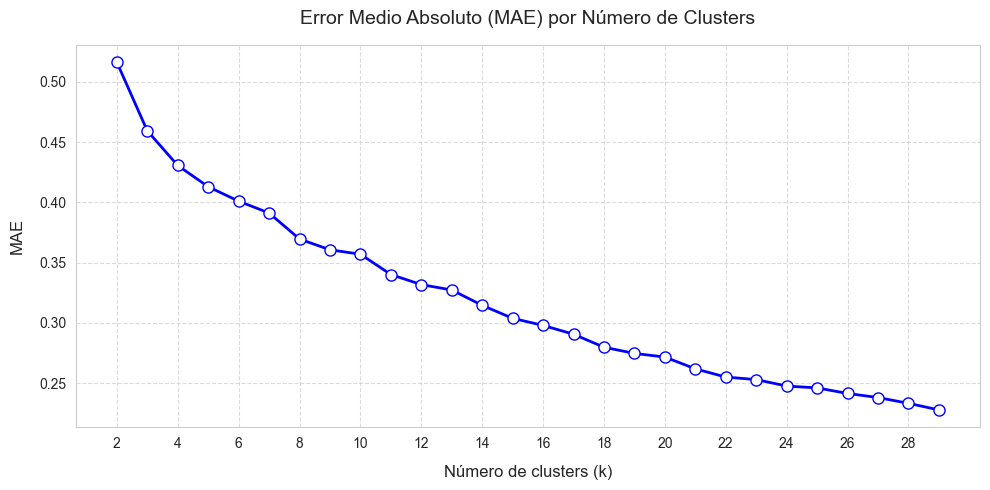

In [219]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))

plt.plot(k_values, MAE_values, 'bo-', linewidth=2, markersize=8, markerfacecolor='white')
plt.title('Error Medio Absoluto (MAE) por Número de Clusters', pad=15, fontsize=14)
plt.xlabel('Número de clusters (k)', labelpad=10, fontsize=12)
plt.ylabel('MAE', labelpad=10, fontsize=12)
plt.xticks(k_values[::2])
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() 
plt.show()

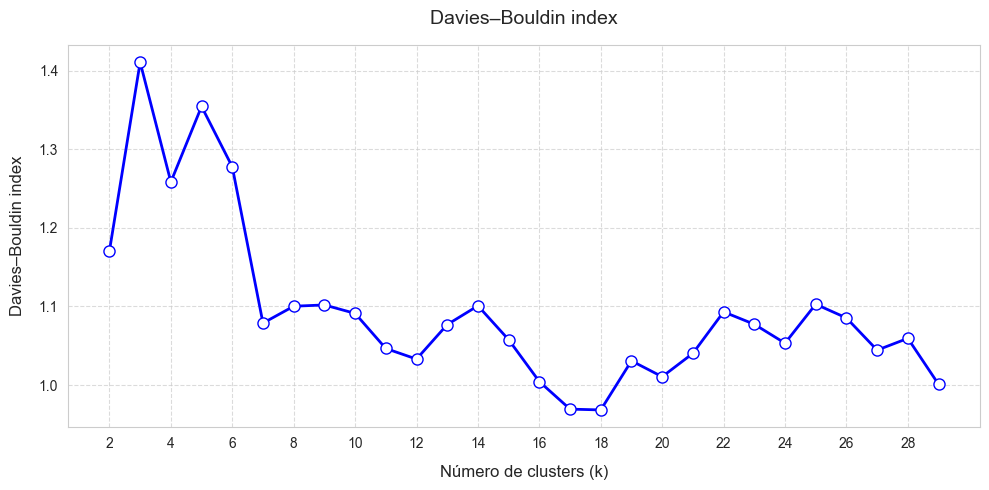

In [220]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))

plt.plot(k_values, dbi_values, 'bo-', linewidth=2, markersize=8, markerfacecolor='white')
plt.title('Davies–Bouldin index', pad=15, fontsize=14)
plt.xlabel('Número de clusters (k)', labelpad=10, fontsize=12)
plt.ylabel('Davies–Bouldin index', labelpad=10, fontsize=12)
plt.xticks(k_values[::2])
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() 
plt.show()

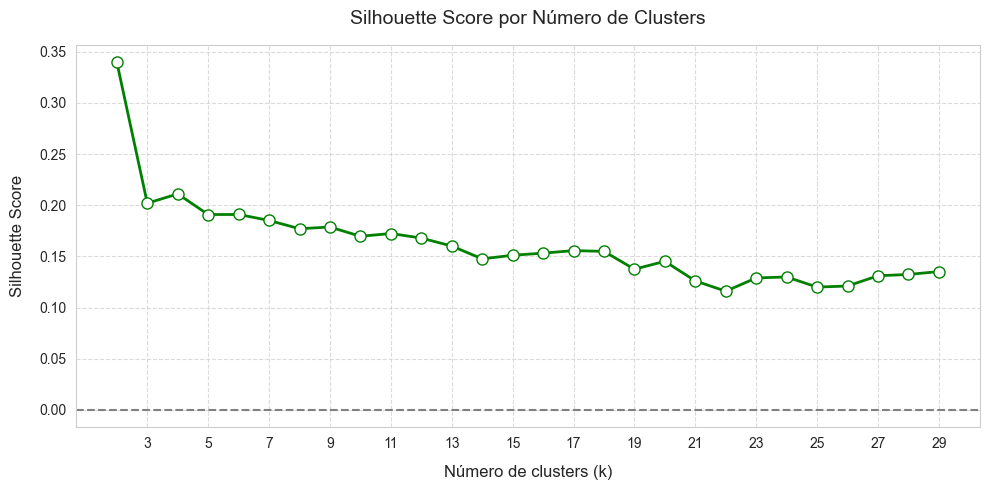

In [221]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))

plt.plot(k_values, silhouette_values, 'go-', linewidth=2, markersize=8, markerfacecolor='white')
plt.title('Silhouette Score por Número de Clusters', pad=15, fontsize=14)
plt.xlabel('Número de clusters (k)', labelpad=10, fontsize=12)
plt.ylabel('Silhouette Score', labelpad=10, fontsize=12)
plt.xticks(k_values[1::2])
plt.grid(True, linestyle='--', alpha=0.7)

plt.axhline(y=0, color='gray', linestyle='--')

plt.tight_layout()
plt.show()

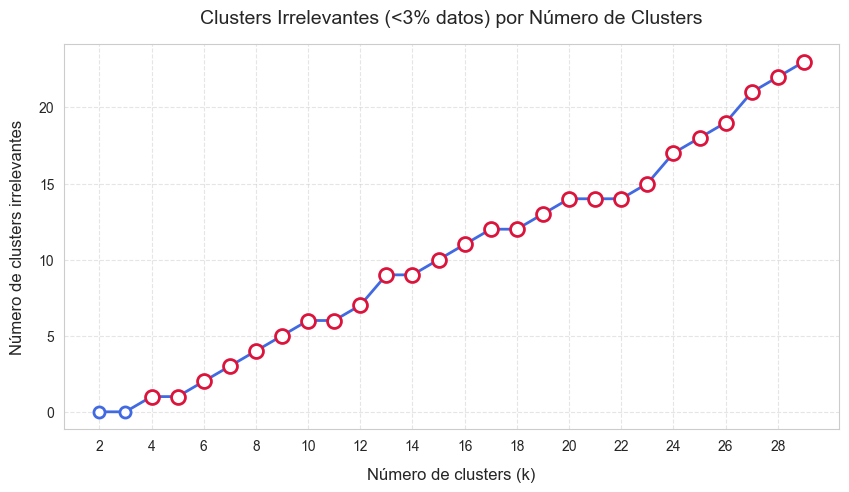

In [222]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, irreleCluster_values, 'o-', 
         color='royalblue', 
         markersize=8,
         markerfacecolor='white',
         markeredgewidth=2,
         linewidth=2)
for k, count in zip(k_values, irreleCluster_values):
    if count > 0:
        plt.plot(k, count, 'o', 
                 color='crimson', 
                 markersize=10,
                 markerfacecolor='white',
                 markeredgewidth=2)
plt.title('Clusters Irrelevantes (<3% datos) por Número de Clusters', 
          pad=15, fontsize=14)
plt.xlabel('Número de clusters (k)', labelpad=10, fontsize=12)
plt.ylabel('Número de clusters irrelevantes', labelpad=10, fontsize=12)
plt.xticks(k_values[::2])
plt.grid(True, linestyle='--', alpha=0.5)

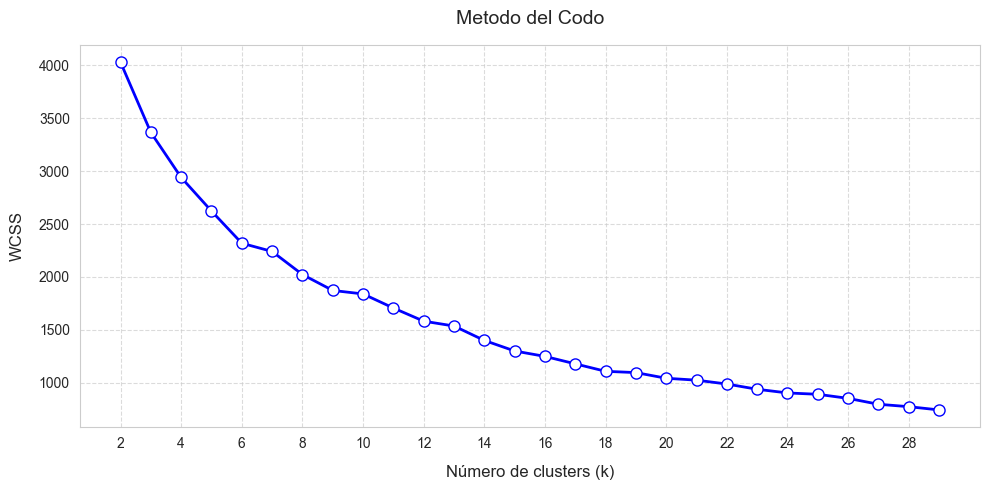

In [223]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))

plt.plot(k_values, wcss_values, 'bo-', linewidth=2, markersize=8, markerfacecolor='white')
plt.title('Metodo del Codo', pad=15, fontsize=14)
plt.xlabel('Número de clusters (k)', labelpad=10, fontsize=12)
plt.ylabel('WCSS', labelpad=10, fontsize=12)
plt.xticks(k_values[::2])
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() 
plt.show()

## Algorithm K-ISAC_TLP procedure
**Input:**
```python
// DATA: values for 𝑘 to be considered in the range
// defined by the experts
𝑘_𝑣𝑎𝑙𝑢𝑒𝑠[𝑘𝑚𝑖𝑛, 𝑘𝑚𝑎𝑥] = 𝑘𝑚𝑖𝑛, 𝑘𝑚𝑖𝑛 + 1, ..., 𝑘𝑚𝑎𝑥
// DATA: List with MAE values measured for different 𝑘 values
// For simplicity, assume that indexes are named 𝑘𝑚𝑖𝑛, 𝑘𝑚𝑖𝑛 + 1, ..., 𝑘𝑚𝑎𝑥
𝑀𝐴𝐸_𝑣𝑎𝑙𝑢𝑒𝑠[𝑘𝑚𝑖𝑛, 𝑘𝑚𝑎𝑥]
// DATA: List with the number of irrelevant clusters modeled for
// different 𝑘 values
// For simplicity, assume that indexes are named 𝑘𝑚𝑖𝑛, 𝑘𝑚𝑖𝑛 + 1, ..., 𝑘𝑚𝑎𝑥
𝑖𝑟𝑟𝑒𝑙𝐶𝑙𝑢𝑠𝑡𝑒𝑟_𝑣𝑎𝑙𝑢𝑒𝑠[𝑘𝑚𝑖𝑛, 𝑘𝑚𝑎𝑥]
```
**Output:**
```python
// values for 𝑘 that meet the criteria defined by experts
𝑏𝑒𝑠𝑡_𝑘_𝑣𝑎𝑙𝑢𝑒𝑠[]
```
**Procedure:**
```python
// Configure parameters before calling ISAC method
𝑑𝑖𝑠𝑡𝑎𝑛𝑐𝑒𝐵𝑒𝑡𝑤𝑒𝑒𝑛𝑇𝑟𝑖𝑎𝑛𝑔𝑙𝑒𝑃𝑜𝑖𝑛𝑡𝑠 ← 3;
𝑐𝑜𝑛𝑠𝑒𝑐𝑢𝑡𝑆𝑡𝑎𝑏𝑖𝑙𝑖𝑡𝑦 ← 3;
// Area threshold for MAE curve
𝑀𝐴𝐸_𝑎𝑟𝑒𝑎𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑 ← 𝑒𝑠𝑡𝑖𝑚𝑎𝑡𝑒𝐴𝑑𝑎𝑝𝑡𝑖𝑣𝑒𝐴𝑟ｅ𝑎𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑(𝑘_𝑣𝑎𝑙𝑢𝑒𝑠,
                                           𝑀𝐴𝐸_𝑣𝑎𝑙𝑢𝑒𝑠,
                                           𝑑𝑖𝑠𝑡𝑎𝑛𝑐𝑒𝐵𝑒𝑡𝑤𝑒𝑒𝑛𝑇𝑟𝑖𝑎𝑛𝑔𝑙𝑒𝑃𝑜𝑖𝑛𝑡𝑠);
// Slope threshold for MAE curve
𝑀𝐴𝐸_𝑠𝑙𝑜𝑝𝑒𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑 ← 𝑒𝑠𝑡𝑖𝑚𝑎𝑡𝑒𝐴𝑑𝑎𝑝𝑡𝑖𝑣𝑒𝑆𝑙𝑜𝑝𝑒𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑(𝑘_𝑣𝑎𝑙𝑢𝑒𝑠,
                                            𝑀𝐴𝐸_𝑣𝑎𝑙𝑢𝑒𝑠);
// Area threshold for curve with number of irrelevant clusters
𝑖𝑟𝑟𝑒𝑙_𝑎𝑟𝑒𝑎𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑 ← 1.5;
// Slope threshold for curve with number of irrelevant clusters (degrees)
𝑖𝑟𝑟𝑒𝑙_𝑠𝑙𝑜𝑝𝑒𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑 ← 22.5;
// Variables to store best 𝑘 values for every curve
𝑏𝑒𝑠𝑡_𝑘_𝑣𝑎𝑙𝑢𝑒𝑠_𝑀𝐴𝐸[] ← 𝐼𝑆𝐴𝐶(𝑘_𝑣𝑎𝑙𝑢𝑒𝑠, 𝑀𝐴𝐸_𝑣𝑎𝑙𝑢𝑒𝑠,
                     𝑑𝑖𝑠𝑡𝑎𝑛𝑐𝑒𝐵𝑒𝑡𝑤𝑒𝑒𝑛𝑇𝑟𝑖𝑎𝑛𝑔𝑙𝑒𝑃𝑜𝑖𝑛𝑡𝑠,
                     𝑐𝑜𝑛𝑠𝑒𝑐𝑢𝑡𝑆𝑡𝑎𝑏𝑖𝑙𝑖𝑡𝑦,
                     𝑀𝐴𝐸_𝑎𝑟𝑒𝑎𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑, 𝑀𝐴𝐸_𝑠𝑙𝑜𝑝𝑒𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑);
𝑏𝑒𝑠𝑡_𝑘_𝑣𝑎𝑙𝑢𝑒𝑠_𝑖𝑟𝑟𝑒𝑙[] ← 𝐼𝑆𝐴𝐶(𝑘_𝑣𝑎𝑙𝑢𝑒𝑠, 𝑖𝑟𝑟𝑒𝑙𝐶𝑙𝑢𝑠𝑡𝑒𝑟_𝑣𝑎𝑙𝑢𝑒𝑠,
                      𝑑𝑖𝑠𝑡𝑎𝑛𝑐𝑒𝐵𝑒𝑡𝑤𝑒𝑒𝑛𝑇𝑟𝑖𝑎𝑛𝑔𝑙𝑒𝑃𝑜𝑖𝑛𝑡𝑠,
                      𝑐𝑜𝑛𝑠𝑒𝑐𝑢𝑡𝑆𝑡𝑎𝑏𝑖𝑙𝑖𝑡𝑦,
                      𝑖𝑟𝑟𝑒𝑙_𝑎𝑟𝑒𝑎𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑, 𝑖𝑟𝑟𝑒𝑙_𝑠𝑙𝑜𝑝𝑒𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑);
𝑏𝑒𝑠𝑡_𝑘_𝑣𝑎𝑙𝑢𝑒𝑠[] ← 𝑐𝑜𝑚𝑚𝑜𝑛𝑉𝑎𝑙𝑢𝑒𝑠𝑂𝑛(𝑏𝑒𝑠𝑡_𝑘_𝑣𝑎𝑙𝑢𝑒𝑠_𝑀𝐴𝐸,
                         𝑏𝑒𝑠𝑡_𝑘_𝑣𝑎𝑙𝑢𝑒𝑠_𝑖𝑟𝑟𝑒𝑙[]);
```

> **Nota:** En el documento, se explica que los umbrales de área y pendiente no son adaptativos en los "irreleant clusters" por diseño.  Los umbrales se establecen de forma fija para evitar detecciones tempranas e inconsistentes, y para reducir los requisitos de estabilidad excesivamente estrictos que requerirían escenarios perfectos. 

In [224]:
# Utils
def random_color():
    x = [0, 1, 2]
    y = [0, 1, 2]
    r = random.random()
    b = random.random()
    g = random.random()
    color_ = (r, g, b)
    return color_

def calculateArea(p1,p2,p3):
    areaTriangle = abs (1/2 * ( ( (p2[0]*p1[1])-(p1[0]*p2[1]) )+ ( (p3[0]*p2[1])-(p2[0]*p3[1]) ) +
    ( (p1[0]*p3[1])-(p3[0]*p1[1]) ) ) )
    return areaTriangle

def calculateSlope(p1,p2):
    slopeTwoPoints = math.degrees(math.atan((p2[1]-p1[1])/(p2[0]-p1[0])))
    return slopeTwoPoints

def RenderTriangle(p1, p2, p3, ax, facecolor, edgecolor="none", linewidth=1):
    p = np.array([p1,p2,p3])
    triangle = plt.Polygon(p, facecolor=facecolor, edgecolor=edgecolor, linewidth=linewidth, alpha=0.7)
    ax.add_patch(triangle)

In [225]:
# --- Función ISAC (adaptada para una sola curva) ---
def ISAC(k_values, measure_values, distanceBetweenPoints=3, consecutStability=3, 
         areaThreshold=None, slopeThreshold=None, curve_type="MAE", ax=None):
    """
    Parámetros:
        - k_values: Lista de valores de k (ej: range(2, 21)).
        - measure_values: Valores de la métrica (MAE o clusters irrelevantes).
        - distanceBetweenPoints: Distancia entre puntos del triángulo (default=3).
        - consecutStability: Número de triángulos consecutivos estables (default=3).
        - areaThreshold: Umbral de área (si None, se calcula para MAE).
        - slopeThreshold: Umbral de pendiente (si None, se calcula para MAE).
        - curve_type: "MAE" o "IRRELE" (para clusters irrelevantes).
        - ax: Eje matplotlib para graficar (opcional).
    """
    kMin = min(k_values)
    kMax = max(k_values)
    measureArray = measure_values

    # Calcular umbrales adaptativos si es MAE
    if curve_type == "MAE" and (areaThreshold is None or slopeThreshold is None):
        p1 = [kMin, measureArray[0]]
        p3 = [kMax, measureArray[-1]]
        p2 = [(kMin + kMax) // 2, measureArray[len(measureArray) // 2]]
        
        # Triángulo pequeño centrado
        p2_less = p2
        p1_less = [p2[0] - distanceBetweenPoints, p2[1] + (p1[1] - p2[1]) * (distanceBetweenPoints / (p2[0] - kMin))]
        p3_less = [p2[0] + distanceBetweenPoints, p2[1] + (p3[1] - p2[1]) * (distanceBetweenPoints / (kMax - p2[0]))]
        
        areaThreshold = calculateArea(p1_less, p2_less, p3_less)
        slopeThreshold = calculateSlope(p1, p3)

    # Umbrales fijos para clusters irrelevantes
    elif curve_type == "IRRELE":
        if areaThreshold is None:
            areaThreshold = 1.5  # Valor fijo igual que en el paper
        if slopeThreshold is None:
            slopeThreshold = 22.5  # Grados fijo igual que en el paper

    # --- Lógica de triangulación ---
    AREAS = []
    SLOPES = []
    positionsStopAreas = []
    positionsStopSlopes = []

    for k in range(0, len(measureArray) - (distanceBetweenPoints * 2)):
        p1 = [k + kMin, measureArray[k]]
        p2 = [k + kMin + distanceBetweenPoints, measureArray[k + distanceBetweenPoints]]
        p3 = [k + kMin + (distanceBetweenPoints * 2), measureArray[k + (distanceBetweenPoints * 2)]]

        area = calculateArea(p1, p2, p3)
        slope = calculateSlope(p1, p3)

        AREAS.append(area)
        SLOPES.append(slope)

        # Criterio de área
        if area <= areaThreshold:
            positionsStopAreas.append(k + kMin)
        # Criterio de pendiente
        if slope >= slopeThreshold:
            positionsStopSlopes.append(k + kMin)

    # Encontrar k óptimos (intersección de criterios)
    common_k_values = list(set(positionsStopAreas) & set(positionsStopSlopes))
    best_k = min(common_k_values) if common_k_values else min(positionsStopAreas)

    # --- Visualización (opcional) ---
    if ax is not None:
        ax.plot(k_values, measureArray, marker="o", color="red", markersize=2, linewidth=1)
        ax.set_xlabel("k")
        ax.set_ylabel("MAE" if curve_type == "MAE" else "Clusters irrelevantes")
        ax.set_title(f"Curva de {curve_type}")

        # Resaltar triángulos válidos
        if best_k is not None:
            num_triangles = 3
            colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in range(num_triangles)]

            for i, offset in enumerate(range(num_triangles)):
                p1 = [best_k + offset, measureArray[best_k - kMin + offset]]
                p2 = [best_k + offset + distanceBetweenPoints, measureArray[best_k - kMin + offset + distanceBetweenPoints]]
                p3 = [best_k + offset + (distanceBetweenPoints * 2), measureArray[best_k - kMin + offset + (distanceBetweenPoints * 2)]]
                RenderTriangle(p1, p2, p3, ax, facecolor=colors[i], edgecolor="black", linewidth=2)

    return {
    "AREAS": AREAS,
    "SLOPES": SLOPES,
    "k_area_true": positionsStopAreas,
    "k_slope_true": positionsStopSlopes,
    "k_common": common_k_values,
    "best_k": best_k
    }

In [226]:
def k_ISAC_TLP(k_values, MAE_values, irreleCluster_values, distanceBetweenPoints=3, consecutStability=3):
    """
    Muestra resultados detallados para ambas curvas y combina los k óptimos.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    results_mae = ISAC(
        k_values, MAE_values, distanceBetweenPoints, consecutStability,
        areaThreshold=None, slopeThreshold=None, curve_type="MAE", ax=ax1
    )

    results_irrele = ISAC(
        k_values, irreleCluster_values, distanceBetweenPoints, consecutStability,
        areaThreshold=1.5, slopeThreshold=22.5, curve_type="IRRELE", ax=ax2
    )

    print("\n--- Resultados para MAE ---")
    print("Áreas de triángulos:", [round(a, 2) for a in results_mae["AREAS"]])
    print("Pendientes de triángulos:", [round(s, 2) for s in results_mae["SLOPES"]])
    print("K values donde área es TRUE:", results_mae["k_area_true"])
    print("K values donde pendiente es TRUE:", results_mae["k_slope_true"])
    print("K values comunes:", results_mae["k_common"])
    print("Mejor k (MAE):", results_mae["best_k"])

    print("\n--- Resultados para Clusters Irrelevantes ---")
    print("Áreas de triángulos:", [round(a, 2) for a in results_irrele["AREAS"]])
    print("Pendientes de triángulos:", [round(s, 2) for s in results_irrele["SLOPES"]])
    print("K values donde área es TRUE:", results_irrele["k_area_true"])
    print("K values donde pendiente es TRUE:", results_irrele["k_slope_true"])
    print("K values comunes:", results_irrele["k_common"])
    print("Mejor k (Clusters irrelevantes):", results_irrele["best_k"])

    print("\n--- Resultado Final ---")
    k_common_mae = set(results_mae["k_common"])
    k_common_irrele = set(results_irrele["k_common"])

    interseccion_comun = sorted(k_common_mae & k_common_irrele)

    if interseccion_comun:
        best_k = interseccion_comun[0]
        print(f"Mejor k común en ambas curvas: {best_k}")
    else:
        print("No hay valores comunes entre ambos criterios. Se tomarán decisiones individuales.")
        best_k = min(results_mae["best_k"], results_irrele["best_k"])

    plt.tight_layout()
    plt.show()

    return best_k


--- Resultados para MAE ---
Áreas de triángulos: [0.09, 0.03, 0.01, 0.02, 0.02, 0.01, 0.01, 0.0, 0.0, 0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.01, 0.02, 0.01, 0.01, 0.01, 0.0]
Pendientes de triángulos: [-1.4, -0.94, -0.7, -0.7, -0.66, -0.61, -0.52, -0.54, -0.56, -0.47, -0.5, -0.5, -0.41, -0.4, -0.41, -0.36, -0.31, -0.27, -0.29, -0.23, -0.21, -0.24]
K values donde área es TRUE: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
K values donde pendiente es TRUE: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
K values comunes: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Mejor k (MAE): 7

--- Resultados para Clusters Irrelevantes ---
Áreas de triángulos: [np.float64(3.0), np.float64(1.5), np.float64(1.5), np.float64(1.5), np.float64(1.5), np.float64(0.0), np.float64(1.5), np.float64(1.5), np.float64(1.5), np.float64(0.0), np.float64(1.5), np.float64(0.0), np.float64(1.5), np.float64(0.0), np.float64(1.5), np.float64(1.5)

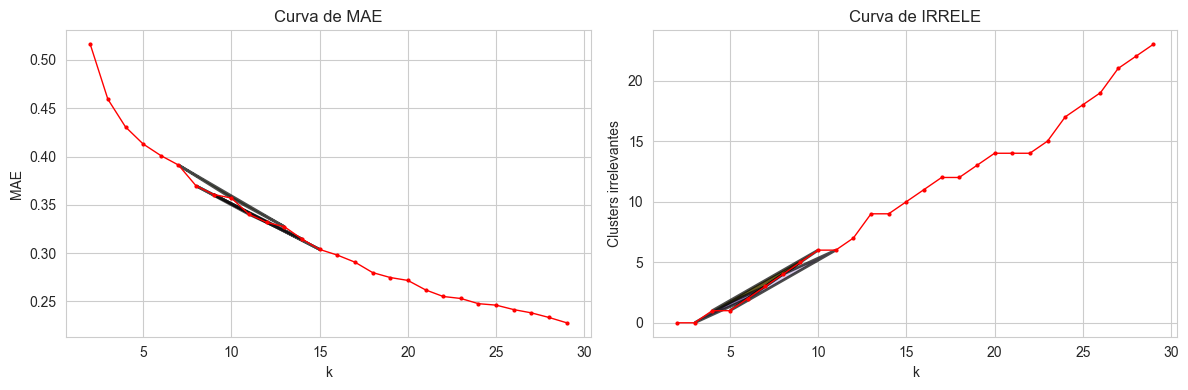

In [227]:
best_k = k_ISAC_TLP(k_values, MAE_values, irreleCluster_values)

## Aplicación de K-Means con el Número Óptimo de Clusters

In [228]:
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
kmeans_final.fit(X)
labels = kmeans_final.labels_
centroids = kmeans_final.cluster_centers_

## Guardar el Modelo Final

In [229]:
with open("pkls/kmeans_24h_model_watts.pkl", "wb") as f:
    pickle.dump(kmeans_final, f)

### Variables más influyentes según varianza entre clusters

In [230]:
centroides = pd.DataFrame(
    kmeans_final.cluster_centers_,
    columns=df_features_final.columns
)

variabilidad = centroides.var(axis=0).sort_values(ascending=False)
print(variabilidad)

p25_verano                        11.463045
p25_invierno                      10.730492
mediana_verano                     8.831904
mediana_anual                      8.469400
energia_fft_verano                 7.040776
mediana_invierno                   6.930510
mediana_primavera                  6.902189
media_verano                       5.713270
skewness_verano                    5.272519
media_anual                        5.025490
media_invierno                     4.990195
kurtosis_verano                    4.900398
p75_anual                          4.607742
p75_verano                         4.596130
skewness_anual                     4.436855
energia_fft_anual                  4.393878
media_primavera                    4.157131
p75_primavera                      4.120679
p75_invierno                       4.023867
energia_fft_invierno               4.010187
kurtosis_anual                     3.955871
p25_anual                          3.690792
p75_otoño                       

## Visualización de Resultados de Clustering

In [231]:
cluster_colors = cm.get_cmap('tab10', best_k)

### Visualización de Clusters PCA

In [232]:


# Reducir a 2D para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
centroids_pca = pca.transform(centroids)

### 1. PCA 2D

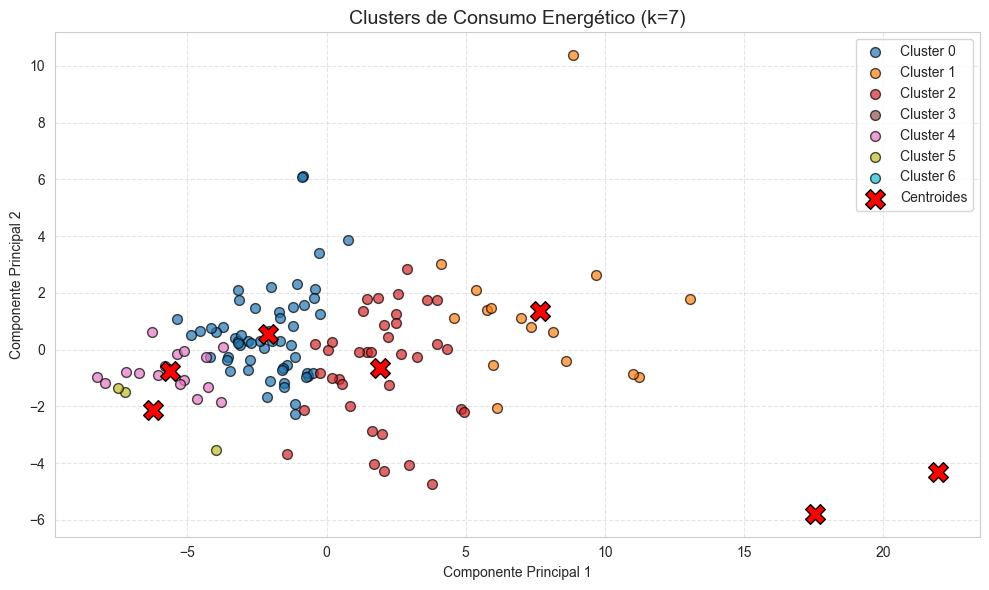

In [233]:
plt.figure(figsize=(10, 6))
for cluster in range(best_k):
    plt.scatter(
        X_pca[labels == cluster, 0],
        X_pca[labels == cluster, 1],
        label=f'Cluster {cluster}',
        color=cluster_colors(cluster),
        alpha=0.7,
        edgecolor='k',
        s=50
    )

# Centroides
plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    marker='X',
    s=200,
    c='red',
    edgecolor='k',
    label='Centroides'
)

plt.title(f'Clusters de Consumo Energético (k={best_k})', fontsize=14)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 2. PCA 3D

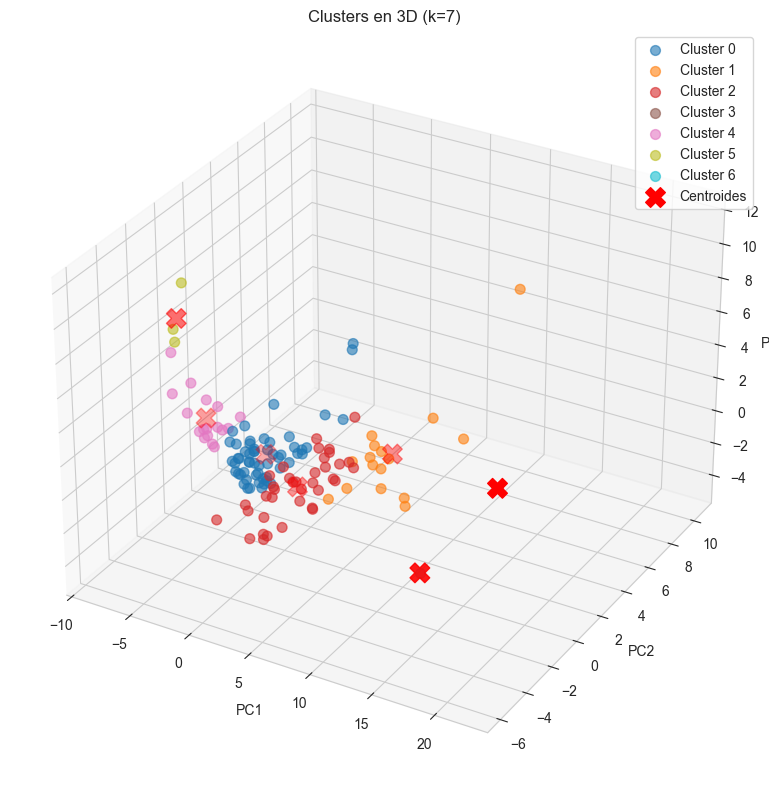

In [234]:
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)
centroids_pca_3d = pca_3d.transform(centroids)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster in range(best_k):
    ax.scatter(
        X_pca_3d[labels == cluster, 0],
        X_pca_3d[labels == cluster, 1],
        X_pca_3d[labels == cluster, 2],
        label=f'Cluster {cluster}',
        color=cluster_colors(cluster),
        alpha=0.6,
        s=50
    )

ax.scatter(
    centroids_pca_3d[:, 0],
    centroids_pca_3d[:, 1],
    centroids_pca_3d[:, 2],
    marker='X',
    s=200,
    c='red',
    label='Centroides'
)

ax.set_title(f'Clusters en 3D (k={best_k})')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.tight_layout()
plt.show()

### Visualización de Clusters de su Consumo Original

In [235]:
df_original = pd.read_csv("../../../data/vertical_preprocessed_data_2.csv", sep=";")

cups_con_nan_invierno = ['ceaddbf817fc', 'd0fbcc1108d8']
df_original = df_original[~df_original['cups'].isin(cups_con_nan_invierno)]

cups_con_nan_otoño = ['83c7fbada9b4', 'b476034a2e3d', 'ba38270a360e']
df_original = df_original[~df_original['cups'].isin(cups_con_nan_otoño)]


df_clusters = df_features_final.reset_index()[['cups']].copy()
df_clusters['cluster'] = labels


df_final = pd.merge(df_original, df_clusters[['cups', 'cluster']], on='cups', how='left')

# Reordenar las columnas para que 'cluster' sea la segunda
column_order = ['cups', 'cluster'] + [col for col in df_final.columns if col not in ['cups', 'cluster']]
df_final = df_final[column_order]

df_final.to_csv('dataset/datos_consumo_con_clusters.csv', index=False, sep=';')

### 1. Distribución de Series por Cluster

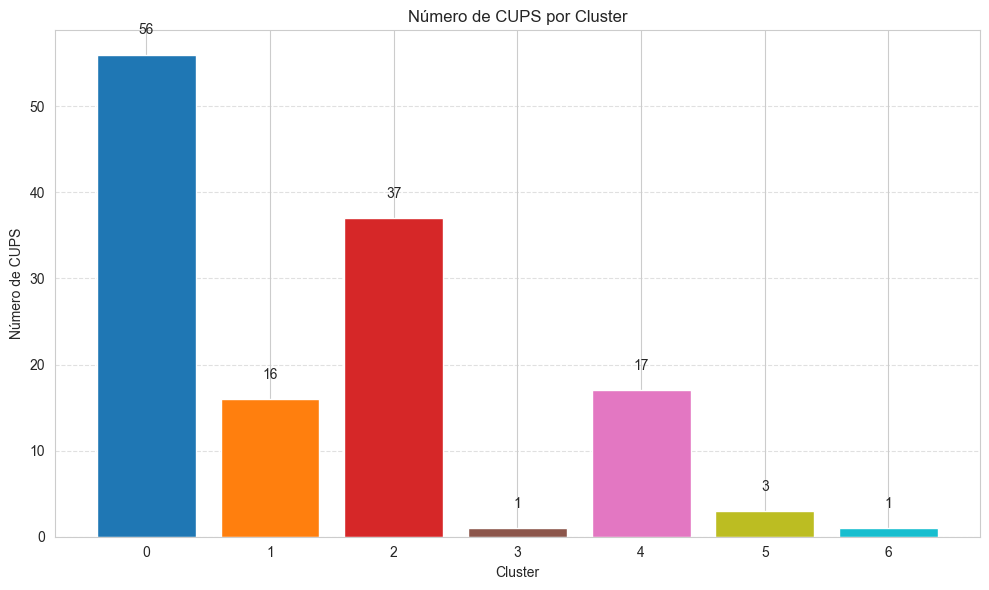

In [236]:
cluster_counts = df_clusters['cluster'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(
    cluster_counts.index.astype(int),
    cluster_counts.values,
    color=[cluster_colors(int(i)) for i in cluster_counts.index]
)

plt.title('Número de CUPS por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de CUPS')
plt.xticks(cluster_counts.index.astype(int))
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 2,
        str(int(height)),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

### 2. Superposición de Series con Centroides

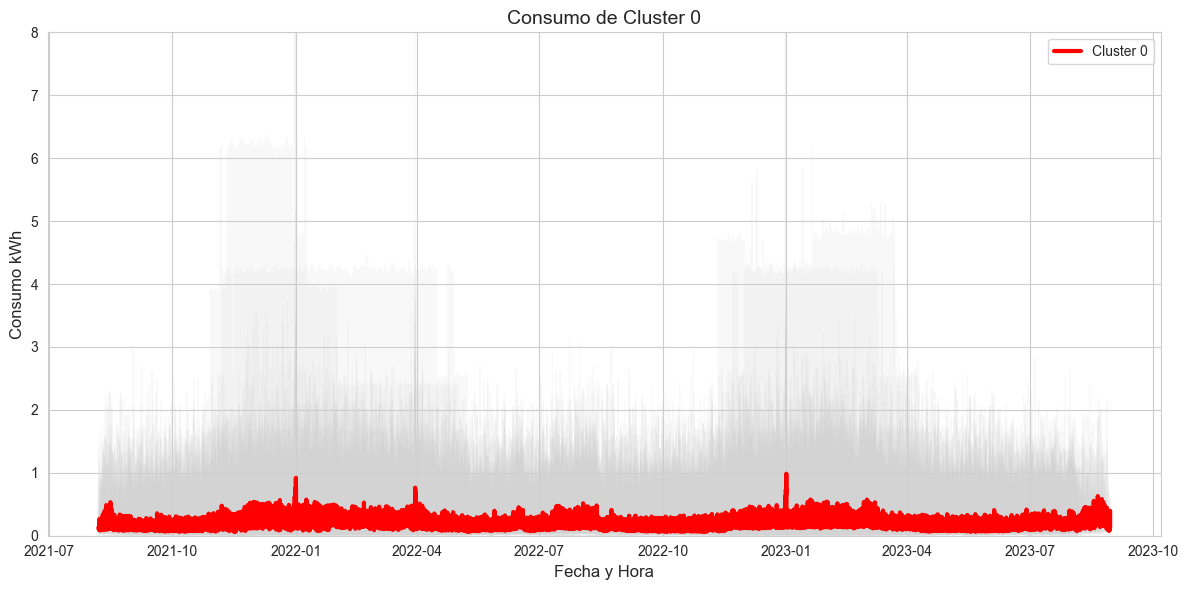

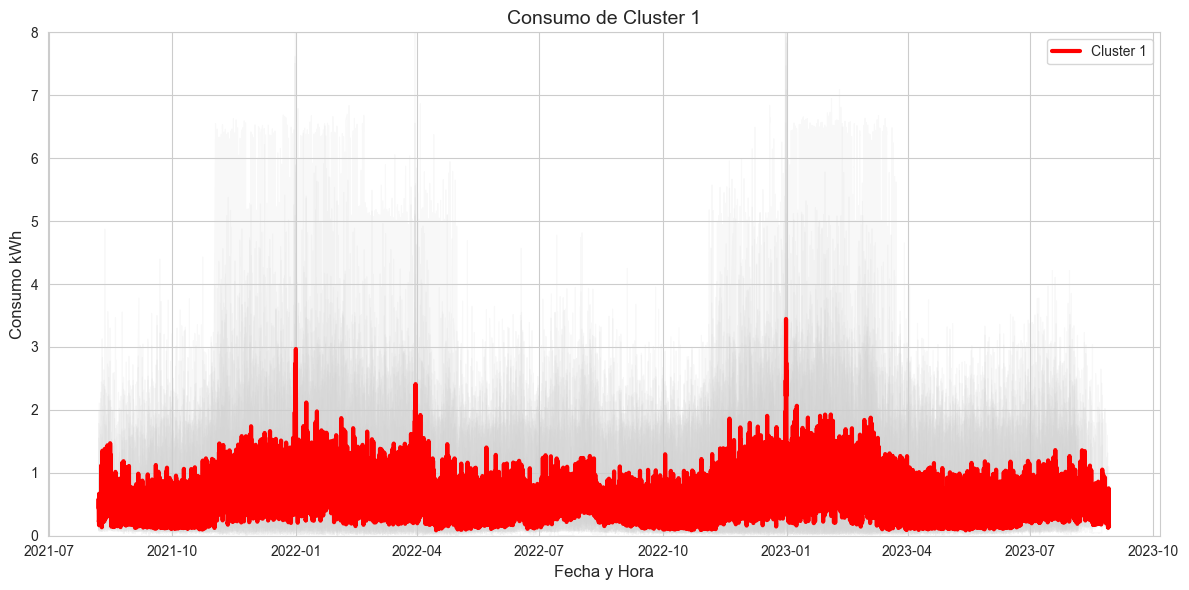

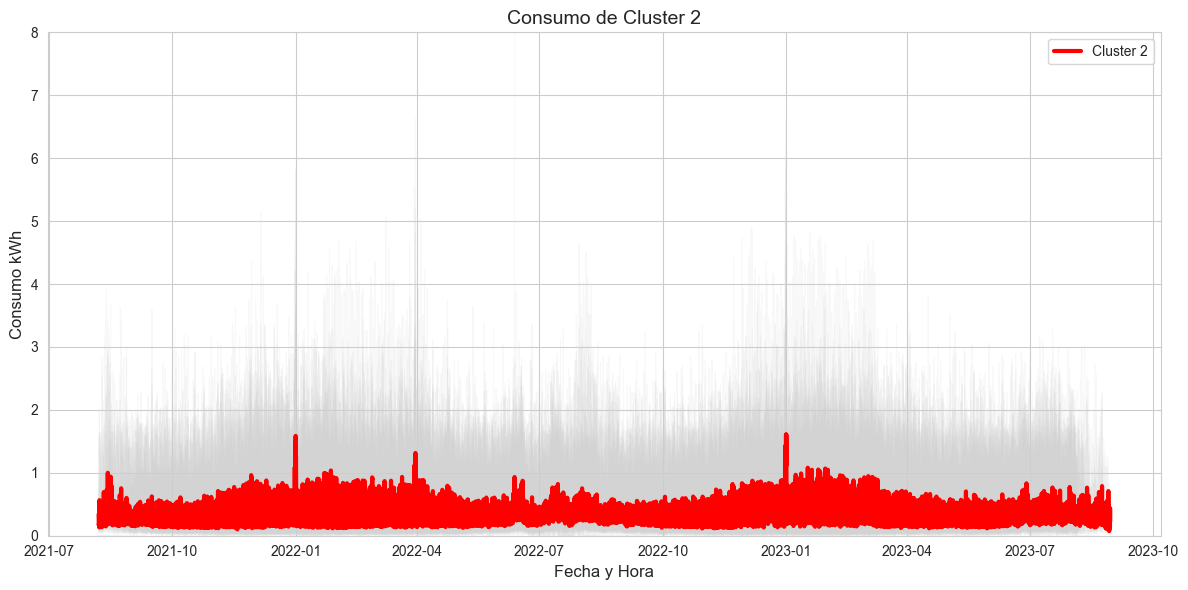

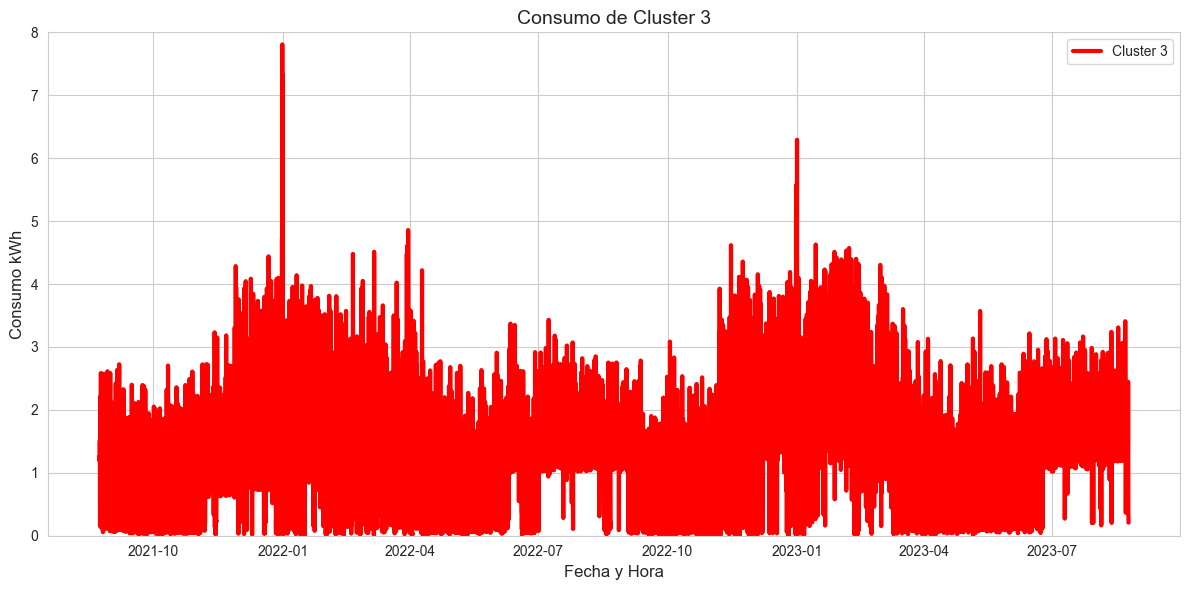

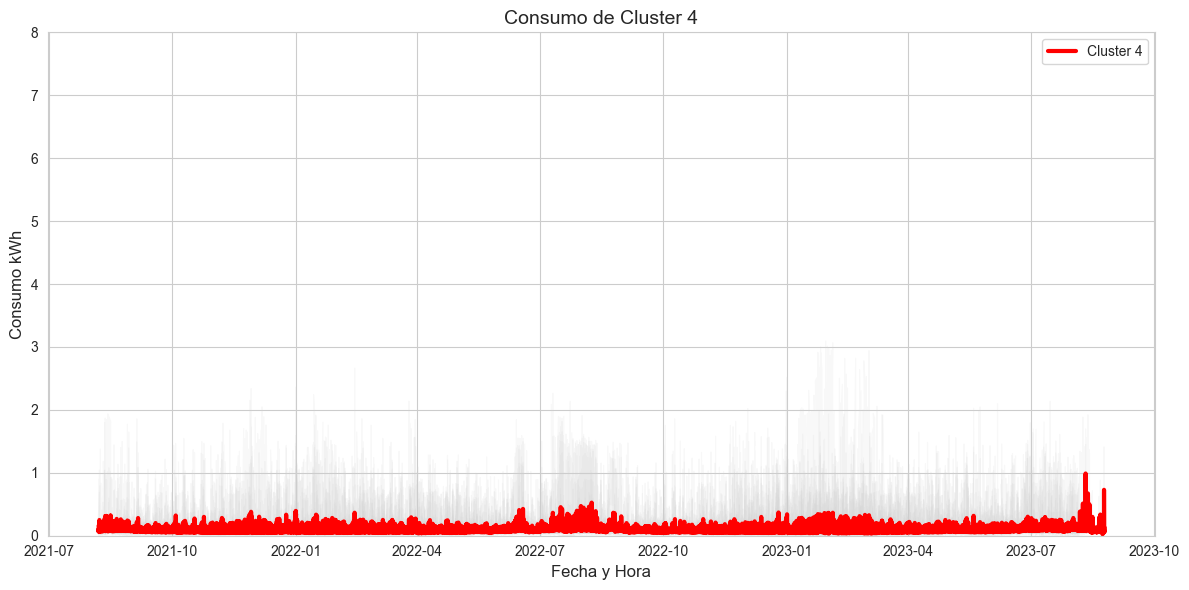

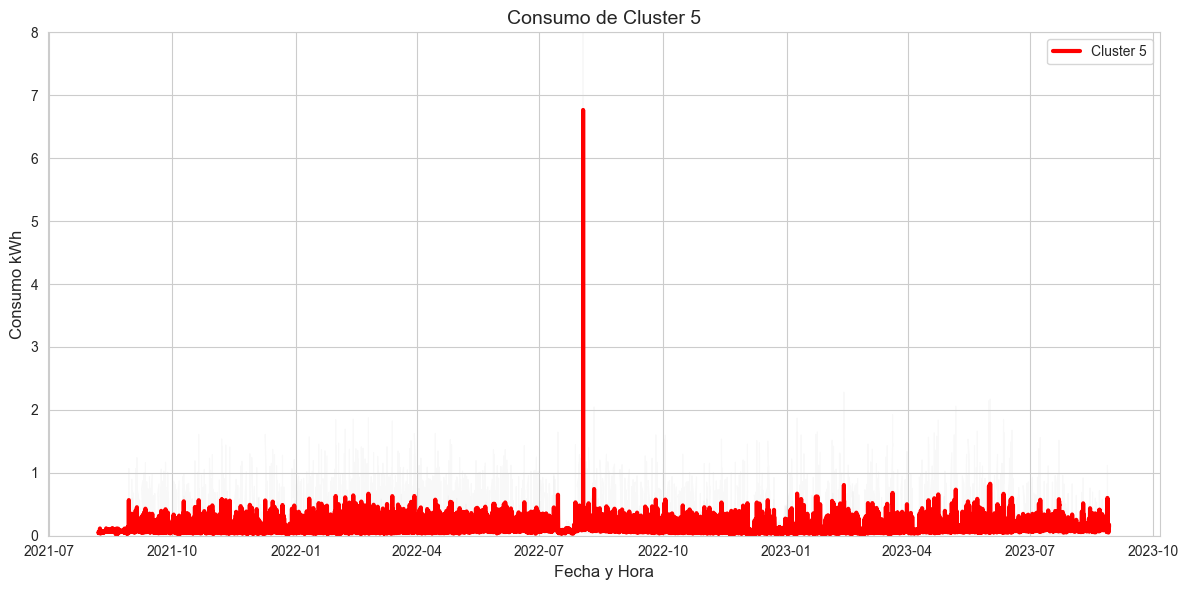

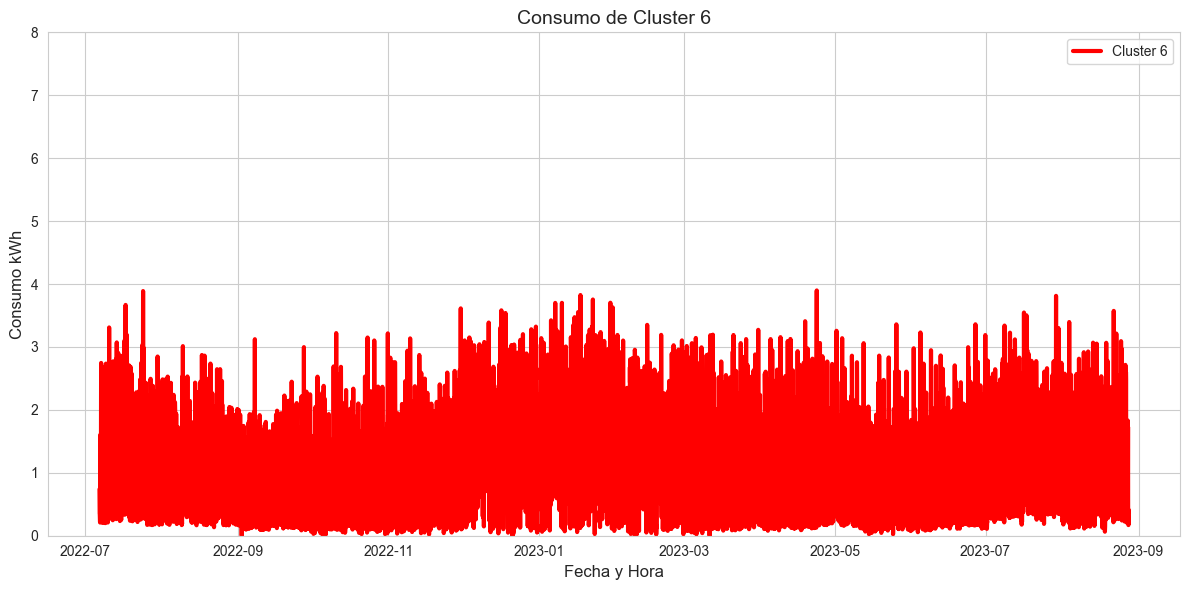

In [237]:
df = pd.read_csv("dataset/datos_consumo_con_clusters.csv", sep=';')

df['hora'] = df['hora'].astype(int)

df['datetime'] = pd.to_datetime(df['fecha']) + pd.to_timedelta(df['hora'], unit='h')

clusters = sorted(df['cluster'].unique())

for cluster in clusters:
    plt.figure(figsize=(12, 6))

    cluster_data = df[df['cluster'] == cluster]
    
    for cups_id in cluster_data['cups'].unique():
        cups_series = cluster_data[cluster_data['cups'] == cups_id]
        plt.plot(cups_series['datetime'], cups_series['consumo_kWh'], color='lightgray', alpha=0.15, linewidth=0.8)
    
    cluster_center = cluster_data.groupby('datetime')['consumo_kWh'].mean()
    plt.plot(cluster_center.index, cluster_center.values, label=f'Cluster {int(cluster)}', linewidth=3, color='red')

    plt.title(f'Consumo de Cluster {int(cluster)}', fontsize=14)
    plt.xlabel('Fecha y Hora', fontsize=12)
    plt.ylabel('Consumo kWh', fontsize=12)
    plt.grid(True)
    plt.legend()
    
    # Fijar el rango del eje Y de 0 a 8 kWh
    plt.ylim(0, 8)
    
    plt.tight_layout()
    plt.show()
